In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix,roc_curve, auc)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.utils import resample
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.metrics import precision_recall_curve
import shap

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# ====================== 中文显示配置 ======================
plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows系统中文显示
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

In [2]:
#train, test = train_test_split(data, test_size=0.3, random_state=42)
#train.to_csv("D:/shuju/yiyu/train.csv", index=False)
#test.to_csv("D:/shuju/yiyu/test.csv", index=False)
#将2018年数据划分为训练集和测试集

In [3]:
data_train= pd.read_csv('D:/shuju/yiyu/train.csv')
data_test=pd.read_csv('D:/shuju/yiyu/test.csv')
data_val=pd.read_csv('D:/shuju/yiyu/2013nian.csv')

In [4]:
if data_train.isna().any().any():
    print("数据data_train中存在缺失值")
else:
    print("数据data_train完整，无缺失值")
if data_test.isna().any().any():
    print("数据data_test中存在缺失值")
else:
    print("数据data_test完整，无缺失值")
if data_val.isna().any().any():
    print("数据data_val中存在缺失值")
else:
    print("数据data_val完整，无缺失值")

数据data_train完整，无缺失值
数据data_test完整，无缺失值
数据data_val完整，无缺失值


In [5]:
Y_train=data_train['yiyu']
X_train=data_train[['gender','srh','adlab_c','arthre','digeste','retire','satlife','sleep','disability','shangwang'
        ,'hope','fall_down','eyesight_close','hear','edu','pension','tengtong']]

In [6]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
x_train, y_train = smote.fit_resample(X_train, Y_train)
count=y_train.value_counts()
count

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


yiyu
0    1368
1    1368
Name: count, dtype: int64

In [7]:
y_test=data_test['yiyu']
x_test=data_test[['gender','srh','adlab_c','arthre','digeste','retire','satlife','sleep','disability','shangwang'
        ,'hope','fall_down','eyesight_close','hear','edu','pension','tengtong']]

In [8]:
y_val=data_val['yiyu']
x_val=data_val[['gender','srh','adlab_c','arthre','digeste','retire','satlife','sleep','disability','shangwang'
        ,'hope','fall_down','eyesight_close','hear','edu','pension','tengtong']]

In [9]:
x_train

,gender,srh,adlab_c,arthre,digeste,retire,satlife,sleep,disability,shangwang,hope,fall_down,eyesight_close,hear,edu,pension,tengtong
0,2,3,0,1,0,0,3,8.000000,1,0,8,0,3,3,3,1,0
1,1,5,0,0,1,0,3,4.500000,0,0,1,0,2,2,1,0,1
2,1,3,1,0,0,1,3,4.000000,0,1,1,0,2,2,3,1,0
3,1,2,0,0,0,1,3,6.000000,1,0,3,1,2,2,4,1,0
4,2,2,6,1,1,0,3,7.500000,0,0,8,0,2,2,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2731,1,2,3,1,1,0,3,9.667245,1,0,1,0,1,2,1,0,0
2732,2,2,0,0,0,0,2,9.000000,0,0,1,0,2,2,2,1,0
2733,2,3,0,0,0,0,3,3.145714,0,0,4,0,2,1,1,0,0
2734,1,3,0,0,0,0,3,4.000000,0,0,1,0,2,2,2,1,0


训练集（无任何修改,模型为默认参数，对模型进行训练）
测试集（寻找模型最佳参数）
验证集（对模型效果进行评价）

In [10]:
from sklearn.model_selection import StratifiedKFold
# 定义skf
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

Logistic

In [11]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [14]:
# 构建处理流程（包含重采样）
logit_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),        # 标准化
    ('clf', LogisticRegression(
        max_iter=1000,  # 增加迭代次数确保收敛
        random_state=42,
        class_weight='balanced'  # 类别权重平衡  
    ))
])
# 第一阶段：10折交叉验证训练
print("正在进行10折交叉验证训练...")
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_metrics = []

for fold_idx, (train_idx, valid_idx) in enumerate(outer_cv.split(x_train, y_train)):
    # 使用 .iloc 基于位置索引行数据
    x_fold_train, y_fold_train = x_train.iloc[train_idx], y_train.iloc[train_idx]
    x_fold_valid, y_fold_valid = x_train.iloc[valid_idx], y_train.iloc[valid_idx]
    # 训练模型（使用完整流程）
    logit_pipeline.fit(x_fold_train, y_fold_train)
    
    # 预测与评估
    y_pred = logit_pipeline.predict(x_fold_valid)
    y_proba = logit_pipeline.predict_proba(x_fold_valid)[:, 1]
    
    tn, fp, fn, tp = confusion_matrix(y_fold_valid, y_pred).ravel()
    fold_metrics = {
        'Accuracy': accuracy_score(y_fold_valid, y_pred),
        'Precision': precision_score(y_fold_valid, y_pred),
        'Recall': recall_score(y_fold_valid, y_pred),
        'Specificity': tn / (tn + fp),
        'F1': f1_score(y_fold_valid, y_pred),
        'AUC': roc_auc_score(y_fold_valid, y_proba)
    }
    cv_metrics.append(fold_metrics)
    
    print(f"Fold {fold_idx+1}: "
          f"Acc={fold_metrics['Accuracy']:.4f} | "
          f"AUC={fold_metrics['AUC']:.4f}")

# 汇总交叉验证结果
cv_df = pd.DataFrame(cv_metrics)
print("\n 交叉验证平均指标:")
print(cv_df.mean().to_frame().T.round(4))

# 第二阶段：网格搜索调参
print("\n 开始网格搜索优化...")
param_grid = [
    {
        'clf__penalty': ['l1', 'l2'],
        'clf__C': [0.1,0.01,0.5],
        'clf__solver': ['liblinear', 'saga'],  # 这些solver支持L1/L2  
    }
]
LOgrid_search = GridSearchCV(
    estimator=logit_pipeline,
    param_grid=param_grid,  # 使用分组的参数网格
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

LOgrid_search.fit(x_train, y_train)

print("\n 最佳参数组合:")
for param, value in LOgrid_search.best_params_.items():
    print(f"{param}: {value}")

# 第三阶段：最终模型评估
LOfinal_model = LOgrid_search.best_estimator_
LOtest_pred = LOfinal_model.predict(x_test)
LOtest_proba = LOfinal_model.predict_proba(x_test)[:, 1]

# 计算所有指标
tn, fp, fn, tp = confusion_matrix(y_test, LOtest_pred).ravel()
LOtest_metrics = {
    'Accuracy': accuracy_score(y_test, LOtest_pred),
    'Precision': precision_score(y_test, LOtest_pred),
    'Recall': recall_score(y_test, LOtest_pred),
    'Specificity': tn / (tn + fp),
    'F1': f1_score(y_test, LOtest_pred),
    'AUC': roc_auc_score(y_test, LOtest_proba)
}
print(LOtest_metrics)

正在进行10折交叉验证训练...
Fold 1: Acc=0.7883 | AUC=0.8808
Fold 2: Acc=0.7372 | AUC=0.8025
Fold 3: Acc=0.7664 | AUC=0.8634
Fold 4: Acc=0.7190 | AUC=0.7839
Fold 5: Acc=0.7518 | AUC=0.8238
Fold 6: Acc=0.7847 | AUC=0.8549
Fold 7: Acc=0.7436 | AUC=0.8377
Fold 8: Acc=0.7436 | AUC=0.8405
Fold 9: Acc=0.7875 | AUC=0.8664
Fold 10: Acc=0.7436 | AUC=0.8141

 交叉验证平均指标:
   Accuracy  Precision  Recall  Specificity      F1     AUC
0    0.7566     0.7555  0.7602       0.7529  0.7574  0.8368

 开始网格搜索优化...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

 最佳参数组合:
clf__C: 0.1
clf__penalty: l1
clf__solver: saga
{'Accuracy': 0.740139211136891, 'Precision': 0.6050156739811913, 'Recall': 0.6632302405498282, 'Specificity': 0.7793345008756567, 'F1': 0.6327868852459017, 'AUC': 0.7995498341969536}


In [15]:
LOfinal_model = LOgrid_search.best_estimator_
LOval_pred = LOfinal_model.predict(x_val)
LOval_proba = LOfinal_model.predict_proba(x_val)[:, 1]

# 测试集评估
tn, fp, fn, tp = confusion_matrix(y_val, LOval_pred).ravel()
LOval_metrics = {
    'Accuracy': accuracy_score(y_val, LOval_pred),
    'Precision': precision_score(y_val, LOval_pred),
    'Recall': recall_score(y_val, LOval_pred),
    'Specificity': tn / (tn + fp),
    'F1': f1_score(y_val, LOval_pred),
    'AUC': roc_auc_score(y_val, LOval_proba)
}

LOfinal_model = LOgrid_search.best_estimator_
LOval_pred = LOfinal_model.predict(x_train)
LOval_proba = LOfinal_model.predict_proba(x_train)[:, 1]

# 测试集评估
tn, fp, fn, tp = confusion_matrix(y_train, LOval_pred).ravel()
LOtrain_metrics = {
    'Accuracy': accuracy_score(y_train, LOval_pred),
    'Precision': precision_score(y_train, LOval_pred),
    'Recall': recall_score(y_train, LOval_pred),
    'Specificity': tn / (tn + fp),
    'F1': f1_score(y_train, LOval_pred),
    'AUC': roc_auc_score(y_train, LOval_proba)
}
print(LOval_metrics)
print(LOtrain_metrics)

{'Accuracy': 0.7240704500978473, 'Precision': 0.5231481481481481, 'Recall': 0.7483443708609272, 'Specificity': 0.7138888888888889, 'F1': 0.6158038147138964, 'AUC': 0.795989698307579}
{'Accuracy': 0.7616959064327485, 'Precision': 0.7590448625180898, 'Recall': 0.7668128654970761, 'Specificity': 0.756578947368421, 'F1': 0.7629090909090909, 'AUC': 0.8414629715126023}


支持向量机

In [17]:
# 构建处理流程（包含重采样）
svm_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),        # 标准化（SVM必需）
    ('clf', SVC(
        probability=True,  # 启用概率预测（AUC必需）
        class_weight='balanced', 
        random_state=42,
        cache_size=1000    # 提升大样本训练速度
    ))
])

# 第一阶段：10折交叉验证训练
print(" 正在进行10折交叉验证训练...")
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_metrics = []

for fold_idx, (train_idx, valid_idx) in enumerate(outer_cv.split(x_train, y_train)):
    x_fold_train, y_fold_train = x_train.iloc[train_idx], y_train.iloc[train_idx]
    x_fold_valid, y_fold_valid = x_train.iloc[valid_idx], y_train.iloc[valid_idx]
    
    # 训练模型（使用完整流程）
    svm_pipeline.fit(x_fold_train, y_fold_train)
    
    # 预测与评估
    y_pred = svm_pipeline.predict(x_fold_valid)
    y_proba = svm_pipeline.predict_proba(x_fold_valid)[:, 1]
    
    tn, fp, fn, tp = confusion_matrix(y_fold_valid, y_pred).ravel()
    fold_metrics = {
        'Accuracy': accuracy_score(y_fold_valid, y_pred),
        'Precision': precision_score(y_fold_valid, y_pred),
        'Recall': recall_score(y_fold_valid, y_pred),
        'Specificity': tn / (tn + fp),
        'F1': f1_score(y_fold_valid, y_pred),
        'AUC': roc_auc_score(y_fold_valid, y_proba)
    }
    cv_metrics.append(fold_metrics)
    
    print(f"Fold {fold_idx+1}: "
          f"Acc={fold_metrics['Accuracy']:.3f} | "
          f"AUC={fold_metrics['AUC']:.3f}")

# 汇总交叉验证结果
cv_df = pd.DataFrame(cv_metrics)
print("\n 交叉验证平均指标:")
print(cv_df.mean().to_frame().T.round(4))

# 第二阶段：网格搜索调参
print("\n 开始网格搜索优化...")
param_grid = {
        'clf__C': [5,10,1],
        'clf__kernel': ['rbf','linear'],
        'clf__gamma': ['scale', 'auto', 0.1],
    }

svcgrid_search = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    refit=True  # 使用最佳参数重新训练
)

svcgrid_search.fit(x_train, y_train)

print("\n 最佳参数组合:")
for param, value in svcgrid_search.best_params_.items():
    print(f"{param}: {value}")
# 第三阶段：最终模型评估
SVCfinal_model = svcgrid_search.best_estimator_
SVCtest_pred = SVCfinal_model.predict(x_test)
SVCtest_proba = SVCfinal_model.predict_proba(x_test)[:, 1]

# 计算所有指标
tn, fp, fn, tp = confusion_matrix(y_test, SVCtest_pred).ravel()
SVCtest_metrics = {
    'Accuracy': accuracy_score(y_test, SVCtest_pred),
    'Precision': precision_score(y_test, SVCtest_pred),
    'Recall': recall_score(y_test, SVCtest_pred),
    'Specificity': tn / (tn + fp),
    'F1': f1_score(y_test, SVCtest_pred),
    'AUC': roc_auc_score(y_test, SVCtest_proba)
}
print(SVCtest_metrics)

 正在进行10折交叉验证训练...
Fold 1: Acc=0.818 | AUC=0.905
Fold 2: Acc=0.745 | AUC=0.818
Fold 3: Acc=0.807 | AUC=0.876
Fold 4: Acc=0.766 | AUC=0.824
Fold 5: Acc=0.781 | AUC=0.868
Fold 6: Acc=0.818 | AUC=0.893
Fold 7: Acc=0.784 | AUC=0.856
Fold 8: Acc=0.788 | AUC=0.869
Fold 9: Acc=0.828 | AUC=0.909
Fold 10: Acc=0.762 | AUC=0.818

 交叉验证平均指标:
   Accuracy  Precision  Recall  Specificity      F1     AUC
0    0.7895     0.7876  0.7938       0.7851  0.7902  0.8637

 开始网格搜索优化...
Fitting 5 folds for each of 18 candidates, totalling 90 fits

 最佳参数组合:
clf__C: 1
clf__gamma: 0.1
clf__kernel: rbf
{'Accuracy': 0.7505800464037123, 'Precision': 0.6347517730496454, 'Recall': 0.6151202749140894, 'Specificity': 0.819614711033275, 'F1': 0.62478184991274, 'AUC': 0.7875223427880188}


In [18]:
SVCfinal_model = svcgrid_search.best_estimator_
SVCval_pred = SVCfinal_model.predict(x_val)
SVCval_proba = SVCfinal_model.predict_proba(x_val)[:, 1]

tn, fp, fn, tp = confusion_matrix(y_val, SVCval_pred).ravel()
SVCval_metrics = {
    'Accuracy': accuracy_score(y_val, SVCval_pred),
    'Precision': precision_score(y_val, SVCval_pred),
    'Recall': recall_score(y_val, SVCval_pred),
    'Specificity': tn / (tn + fp),
    'F1': f1_score(y_val, SVCval_pred),
    'AUC': roc_auc_score(y_val, SVCval_proba)
}


SVCfinal_model = svcgrid_search.best_estimator_
SVCval_pred = SVCfinal_model.predict(x_train)
SVCval_proba = SVCfinal_model.predict_proba(x_train)[:, 1]

# 测试集评估
tn, fp, fn, tp = confusion_matrix(y_train, SVCval_pred).ravel()
SVCtrain_metrics = {
    'Accuracy': accuracy_score(y_train, SVCval_pred),
    'Precision': precision_score(y_train, SVCval_pred),
    'Recall': recall_score(y_train, SVCval_pred),
    'Specificity': tn / (tn + fp),
    'F1': f1_score(y_train, SVCval_pred),
    'AUC': roc_auc_score(y_train, SVCval_proba)
}
print(SVCval_metrics)
print(SVCtrain_metrics)

{'Accuracy': 0.735812133072407, 'Precision': 0.543010752688172, 'Recall': 0.6688741721854304, 'Specificity': 0.7638888888888888, 'F1': 0.599406528189911, 'AUC': 0.7931935246504783}
{'Accuracy': 0.8929093567251462, 'Precision': 0.8847530422333572, 'Recall': 0.9035087719298246, 'Specificity': 0.8823099415204678, 'F1': 0.8940325497287522, 'AUC': 0.951300720734585}


多层感知器

In [45]:
# 构建完整处理流程
mlp_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('clf', MLPClassifier(
        early_stopping=True,
        validation_fraction=0.15,
        n_iter_no_change=10,
        tol=1e-5,
        random_state=42,
        solver='adam'
    ))
])

# 第一阶段：10折交叉验证训练
print(" 正在进行10折交叉验证训练...")
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_metrics = []

for fold_idx, (train_idx, valid_idx) in enumerate(outer_cv.split(x_train, y_train)):
    x_fold_train, y_fold_train = x_train.iloc[train_idx], y_train.iloc[train_idx]
    x_fold_valid, y_fold_valid = x_train.iloc[valid_idx], y_train.iloc[valid_idx]
    
    # 训练模型
    mlp_pipeline.fit(x_fold_train, y_fold_train)
    
    # 预测验证集
    y_pred = mlp_pipeline.predict(x_fold_valid)
    y_proba = mlp_pipeline.predict_proba(x_fold_valid)[:, 1]
    
    # 计算指标
    tn, fp, fn, tp = confusion_matrix(y_fold_valid, y_pred).ravel()
    fold_metrics = {
        'Accuracy': accuracy_score(y_fold_valid, y_pred),
        'Precision': precision_score(y_fold_valid, y_pred),
        'Recall': recall_score(y_fold_valid, y_pred),
        'Specificity': tn / (tn + fp),
        'F1': f1_score(y_fold_valid, y_pred),
        'AUC': roc_auc_score(y_fold_valid, y_proba)
    }
    cv_metrics.append(fold_metrics)
    
    print(f"Fold {fold_idx+1}: "
          f"Acc={fold_metrics['Accuracy']:.3f} | "
          f"AUC={fold_metrics['AUC']:.3f}")

# 汇总交叉验证结果
cv_df = pd.DataFrame(cv_metrics)
print("\n 交叉验证平均指标:")
print(cv_df.mean().to_frame().T.round(4))

# 第二阶段：网格搜索调参
print("\n 开始网格搜索优化...")
param_grid = {
    'clf__hidden_layer_sizes': [(100,), (100,50), (50)],
    'clf__learning_rate_init': [0.01, 0.1,0.001],
    'clf__max_iter':[10,200,100]
}

MLPgrid_search = GridSearchCV(
    estimator=mlp_pipeline,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

MLPgrid_search.fit(x_train, y_train)

print("\n 最佳参数组合:")
for param, value in MLPgrid_search.best_params_.items():
    print(f"{param}: {value}")

# 第三阶段：最终模型评估
MLPfinal_model = MLPgrid_search.best_estimator_
MLPtest_pred = MLPfinal_model.predict(x_test)
MLPtest_proba = MLPfinal_model.predict_proba(x_test)[:, 1]

# 计算所有指标
tn, fp, fn, tp = confusion_matrix(y_test, MLPtest_pred).ravel()
MLPtest_metrics = {
    'Accuracy': accuracy_score(y_test, MLPtest_pred),
    'Precision': precision_score(y_test, MLPtest_pred),
    'Recall': recall_score(y_test, MLPtest_pred),
    'Specificity': tn / (tn + fp),
    'F1': f1_score(y_test, MLPtest_pred),
    'AUC': roc_auc_score(y_test, MLPtest_proba)
}
print(MLPtest_metrics)

 正在进行10折交叉验证训练...
Fold 1: Acc=0.818 | AUC=0.901
Fold 2: Acc=0.737 | AUC=0.802
Fold 3: Acc=0.799 | AUC=0.873
Fold 4: Acc=0.737 | AUC=0.805
Fold 5: Acc=0.777 | AUC=0.832
Fold 6: Acc=0.810 | AUC=0.871
Fold 7: Acc=0.744 | AUC=0.823
Fold 8: Acc=0.751 | AUC=0.850
Fold 9: Acc=0.788 | AUC=0.861
Fold 10: Acc=0.740 | AUC=0.819

 交叉验证平均指标:
   Accuracy  Precision  Recall  Specificity      F1     AUC
0    0.7701      0.769  0.7733       0.7668  0.7708  0.8438

 开始网格搜索优化...
Fitting 5 folds for each of 27 candidates, totalling 135 fits

 最佳参数组合:
clf__hidden_layer_sizes: (100, 50)
clf__learning_rate_init: 0.001
clf__max_iter: 200
{'Accuracy': 0.7354988399071926, 'Precision': 0.6060606060606061, 'Recall': 0.6185567010309279, 'Specificity': 0.7950963222416813, 'F1': 0.6122448979591837, 'AUC': 0.7836014467895596}


In [22]:
MLPfinal_model = MLPgrid_search.best_estimator_
MLPval_pred = MLPfinal_model.predict(x_val)
MLPval_proba = MLPfinal_model.predict_proba(x_val)[:, 1]

# 测试集评估
tn, fp, fn, tp = confusion_matrix(y_val, MLPval_pred).ravel()
MLPval_metrics = {
    'Accuracy': accuracy_score(y_val, MLPval_pred),
    'Precision': precision_score(y_val, MLPval_pred),
    'Recall': recall_score(y_val, MLPval_pred),
    'Specificity': tn / (tn + fp),
    'F1': f1_score(y_val, MLPval_pred),
    'AUC': roc_auc_score(y_val, MLPval_proba)
}

MLPfinal_model = MLPgrid_search.best_estimator_
MLPval_pred = MLPfinal_model.predict(x_train)
MLPval_proba = MLPfinal_model.predict_proba(x_train)[:, 1]

# 测试集评估
tn, fp, fn, tp = confusion_matrix(y_train, MLPval_pred).ravel()
MLPtrain_metrics = {
    'Accuracy': accuracy_score(y_train, MLPval_pred),
    'Precision': precision_score(y_train, MLPval_pred),
    'Recall': recall_score(y_train, MLPval_pred),
    'Specificity': tn / (tn + fp),
    'F1': f1_score(y_train, MLPval_pred),
    'AUC': roc_auc_score(y_train, MLPval_proba)
}
print(MLPval_metrics)
print(MLPtrain_metrics)

{'Accuracy': 0.7064579256360078, 'Precision': 0.5022026431718062, 'Recall': 0.7549668874172185, 'Specificity': 0.6861111111111111, 'F1': 0.6031746031746031, 'AUC': 0.790121412803532}
{'Accuracy': 0.8125, 'Precision': 0.7974947807933194, 'Recall': 0.8377192982456141, 'Specificity': 0.7872807017543859, 'F1': 0.8171122994652407, 'AUC': 0.8931824108272631}


LightGBM

In [23]:
# 构建处理流程（集成SMOTE）
lgbm_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),  # 重采样处理不平衡数据
    ('clf', lgb.LGBMClassifier(
        objective='binary',
        random_state=42,
        n_jobs=-1,
        verbosity=-1  # 隐藏警告信息
    ))
])
# 第一阶段：10折交叉验证训练
print(" 正在进行10折交叉验证训练...")
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_metrics = []

for fold_idx, (train_idx, valid_idx) in enumerate(outer_cv.split(x_train, y_train)):
    x_fold_train, y_fold_train = x_train.iloc[train_idx], y_train.iloc[train_idx]
    x_fold_valid, y_fold_valid = x_train.iloc[valid_idx], y_train.iloc[valid_idx]
    
    # 训练模型（使用完整流程）
    lgbm_pipeline.fit(x_fold_train, y_fold_train)
    
    # 预测与评估
    y_pred = lgbm_pipeline.predict(x_fold_valid)
    y_proba = lgbm_pipeline.predict_proba(x_fold_valid)[:, 1]
    
    tn, fp, fn, tp = confusion_matrix(y_fold_valid, y_pred).ravel()
    fold_metrics = {
        'Accuracy': accuracy_score(y_fold_valid, y_pred),
        'Precision': precision_score(y_fold_valid, y_pred),
        'Recall': recall_score(y_fold_valid, y_pred),
        'Specificity': tn / (tn + fp),
        'F1': f1_score(y_fold_valid, y_pred),
        'AUC': roc_auc_score(y_fold_valid, y_proba)
    }
    cv_metrics.append(fold_metrics)
    
    print(f"Fold {fold_idx+1}: "
          f"Acc={fold_metrics['Accuracy']:.3f} | "
          f"AUC={fold_metrics['AUC']:.3f}")

# 汇总交叉验证结果
cv_df = pd.DataFrame(cv_metrics)
print("\n 交叉验证平均指标:")
print(cv_df.mean().to_frame().T.round(4))

# 第二阶段：网格搜索调参
print("\n 开始网格搜索优化...")
param_grid = {
    'clf__learning_rate': [0.1,0.01], 
    'clf__boosting_type':['gbdt'],
    'clf__subsample': [0.8, 1.0,0.5],      
    'clf__n_estimatators': [1,5,10,20], 
}

GBMgrid_search = GridSearchCV(
    estimator=lgbm_pipeline,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

GBMgrid_search.fit(x_train, y_train)

print("\n 最佳参数组合:")
for param, value in GBMgrid_search.best_params_.items():
    print(f"{param}: {value}")

# 第三阶段：最终模型评估
GBMfinal_model = GBMgrid_search.best_estimator_
GBMtest_pred = GBMfinal_model.predict(x_test)
GBMtest_proba = GBMfinal_model.predict_proba(x_test)[:, 1]

# 计算所有指标
tn, fp, fn, tp = confusion_matrix(y_test, GBMtest_pred).ravel()
GBMtest_metrics = {
    'Accuracy': accuracy_score(y_test, GBMtest_pred),
    'Precision': precision_score(y_test, GBMtest_pred),
    'Recall': recall_score(y_test, GBMtest_pred),
    'Specificity': tn / (tn + fp),
    'F1': f1_score(y_test, GBMtest_pred),
    'AUC': roc_auc_score(y_test, GBMtest_proba)
}
print(GBMtest_metrics)

 正在进行10折交叉验证训练...
Fold 1: Acc=0.836 | AUC=0.913
Fold 2: Acc=0.810 | AUC=0.872
Fold 3: Acc=0.821 | AUC=0.909
Fold 4: Acc=0.796 | AUC=0.890
Fold 5: Acc=0.821 | AUC=0.893
Fold 6: Acc=0.847 | AUC=0.910
Fold 7: Acc=0.817 | AUC=0.907
Fold 8: Acc=0.842 | AUC=0.911
Fold 9: Acc=0.857 | AUC=0.927
Fold 10: Acc=0.766 | AUC=0.867

 交叉验证平均指标:
   Accuracy  Precision  Recall  Specificity      F1     AUC
0    0.8213     0.8169   0.829       0.8136  0.8225  0.8999

 开始网格搜索优化...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

 最佳参数组合:
clf__boosting_type: gbdt
clf__learning_rate: 0.1
clf__n_estimatators: 1
clf__subsample: 0.8
{'Accuracy': 0.7633410672853829, 'Precision': 0.6653992395437263, 'Recall': 0.6013745704467354, 'Specificity': 0.8458844133099825, 'F1': 0.631768953068592, 'AUC': 0.8108160157919126}


In [24]:
GBMfinal_model = GBMgrid_search.best_estimator_
GBMval_pred = GBMfinal_model.predict(x_val)
GBMval_proba = GBMfinal_model.predict_proba(x_val)[:, 1]

tn, fp, fn, tp = confusion_matrix(y_val, GBMval_pred).ravel()
GBMval_metrics = {
    'Accuracy': accuracy_score(y_val, GBMval_pred),
    'Precision': precision_score(y_val, GBMval_pred),
    'Recall': recall_score(y_val, GBMval_pred),
    'Specificity': tn / (tn + fp),
    'F1': f1_score(y_val, GBMval_pred),
    'AUC': roc_auc_score(y_val, GBMval_proba)
}

GBMfinal_model = GBMgrid_search.best_estimator_
GBMval_pred = GBMfinal_model.predict(x_train)
GBMval_proba = GBMfinal_model.predict_proba(x_train)[:, 1]

tn, fp, fn, tp = confusion_matrix(y_train, GBMval_pred).ravel()
GBMtrain_metrics = {
    'Accuracy': accuracy_score(y_train, GBMval_pred),
    'Precision': precision_score(y_train, GBMval_pred),
    'Recall': recall_score(y_train, GBMval_pred),
    'Specificity': tn / (tn + fp),
    'F1': f1_score(y_train, GBMval_pred),
    'AUC': roc_auc_score(y_train, GBMval_proba)
}
print(GBMval_metrics)
print(GBMtrain_metrics)

{'Accuracy': 0.7475538160469667, 'Precision': 0.5604395604395604, 'Recall': 0.6754966887417219, 'Specificity': 0.7777777777777778, 'F1': 0.6126126126126126, 'AUC': 0.8002391464311995}
{'Accuracy': 0.9342105263157895, 'Precision': 0.9255014326647565, 'Recall': 0.9444444444444444, 'Specificity': 0.9239766081871345, 'F1': 0.934876989869754, 'AUC': 0.9857595071987962}


XGBoost

In [12]:
# 构建处理流程
xgb_pipeline = ImbPipeline([
    ('clf', xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    ))
])

# 第一阶段：10折交叉验证训练
print("正在进行10折交叉验证训练...")
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_metrics = []

for fold_idx, (train_idx, valid_idx) in enumerate(outer_cv.split(x_train, y_train)):
    # 正确使用DataFrame索引
    X_fold_train = x_train.iloc[train_idx]
    y_fold_train = y_train.iloc[train_idx]
    X_fold_valid = x_train.iloc[valid_idx]
    y_fold_valid = y_train.iloc[valid_idx]
    
    # 训练模型
    xgb_pipeline.fit(X_fold_train, y_fold_train)
    
    # 预测评估
    y_pred = xgb_pipeline.predict(X_fold_valid)
    y_proba = xgb_pipeline.predict_proba(X_fold_valid)[:, 1]
    
    tn, fp, fn, tp = confusion_matrix(y_fold_valid, y_pred).ravel()
    fold_metrics = {
        'Accuracy': accuracy_score(y_fold_valid, y_pred),
        'Precision': precision_score(y_fold_valid, y_pred),
        'Recall': recall_score(y_fold_valid, y_pred),
        'Specificity': tn / (tn + fp),
        'F1': f1_score(y_fold_valid, y_pred),
        'AUC': roc_auc_score(y_fold_valid, y_proba)
    }
    cv_metrics.append(fold_metrics)
    
    print(f"Fold {fold_idx+1}: "
          f"Acc={fold_metrics['Accuracy']:.4f} | "
          f"AUC={fold_metrics['AUC']:.4f}")

# 汇总交叉验证结果
cv_df = pd.DataFrame(cv_metrics)
print("\n 交叉验证平均指标:")
print(cv_df.mean().to_frame().T.round(4))

# 第二阶段：网格搜索调参
print("\n 开始网格搜索优化...")
param_grid = {
    'clf__learning_rate': [0.001, 0.1,0.01],
    'clf__max_depth': [5,3],
    'clf__subsample': [0.8, 1.0,0.5],
    'clf__n_estimators': [10,50,100],
}

XGBgrid_search = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

XGBgrid_search.fit(x_train, y_train)

print("\n 最佳参数组合:")
for param, value in XGBgrid_search.best_params_.items():
    print(f"{param}: {value}")

# 第三阶段：最终评估
XGBfinal_model = XGBgrid_search.best_estimator_
XGBtest_pred = XGBfinal_model.predict(x_test)
XGBtest_proba = XGBfinal_model.predict_proba(x_test)[:, 1]

# 计算指标
tn, fp, fn, tp = confusion_matrix(y_test, XGBtest_pred).ravel()
XGBtest_metrics = {
    'Accuracy': accuracy_score(y_test, XGBtest_pred),
    'Precision': precision_score(y_test, XGBtest_pred),
    'Recall': recall_score(y_test, XGBtest_pred),
    'Specificity': tn / (tn + fp),
    'F1': f1_score(y_test, XGBtest_pred),
    'AUC': roc_auc_score(y_test, XGBtest_proba)
}
print(XGBtest_metrics)

正在进行10折交叉验证训练...
Fold 1: Acc=0.8358 | AUC=0.9094
Fold 2: Acc=0.7810 | AUC=0.8662
Fold 3: Acc=0.7993 | AUC=0.8984
Fold 4: Acc=0.8066 | AUC=0.9021
Fold 5: Acc=0.8139 | AUC=0.8866
Fold 6: Acc=0.8394 | AUC=0.9093
Fold 7: Acc=0.8242 | AUC=0.9083
Fold 8: Acc=0.8168 | AUC=0.9083
Fold 9: Acc=0.8608 | AUC=0.9304
Fold 10: Acc=0.7619 | AUC=0.8505

 交叉验证平均指标:
   Accuracy  Precision  Recall  Specificity      F1    AUC
0     0.814     0.8066  0.8267       0.8012  0.8163  0.897

 开始网格搜索优化...
Fitting 5 folds for each of 54 candidates, totalling 270 fits

 最佳参数组合:
clf__learning_rate: 0.1
clf__max_depth: 5
clf__n_estimators: 100
clf__subsample: 0.5
{'Accuracy': 0.7749419953596288, 'Precision': 0.6725978647686833, 'Recall': 0.6494845360824743, 'Specificity': 0.8388791593695272, 'F1': 0.6608391608391608, 'AUC': 0.8212817688868026}


In [13]:
XGBfinal_model = XGBgrid_search.best_estimator_
XGBval_pred = XGBfinal_model.predict(x_val)
XGBval_proba = XGBfinal_model.predict_proba(x_val)[:, 1]


tn, fp, fn, tp = confusion_matrix(y_val, XGBval_pred).ravel()
XGBval_metrics = {
    'Accuracy': accuracy_score(y_val, XGBval_pred),
    'Precision': precision_score(y_val, XGBval_pred),
    'Recall': recall_score(y_val, XGBval_pred),
    'Specificity': tn / (tn + fp),
    'F1': f1_score(y_val, XGBval_pred),
    'AUC': roc_auc_score(y_val, XGBval_proba)
}

XGBfinal_model = XGBgrid_search.best_estimator_
XGBval_pred = XGBfinal_model.predict(x_train)
XGBval_proba = XGBfinal_model.predict_proba(x_train)[:, 1]


tn, fp, fn, tp = confusion_matrix(y_train, XGBval_pred).ravel()
XGBtrain_metrics = {
    'Accuracy': accuracy_score(y_train, XGBval_pred),
    'Precision': precision_score(y_train, XGBval_pred),
    'Recall': recall_score(y_train, XGBval_pred),
    'Specificity': tn / (tn + fp),
    'F1': f1_score(y_train, XGBval_pred),
    'AUC': roc_auc_score(y_train, XGBval_proba)
}
print(XGBval_metrics)
print(XGBtrain_metrics)

{'Accuracy': 0.7495107632093934, 'Precision': 0.5608465608465608, 'Recall': 0.7019867549668874, 'Specificity': 0.7694444444444445, 'F1': 0.6235294117647059, 'AUC': 0.8080206033848418}
{'Accuracy': 0.8808479532163743, 'Precision': 0.8695035460992908, 'Recall': 0.8961988304093568, 'Specificity': 0.8654970760233918, 'F1': 0.8826493880489561, 'AUC': 0.9562530992442119}


随机森林机器学习

In [54]:
# 构建处理流程
rf_pipeline = ImbPipeline([
    ('clf', RandomForestClassifier(
        class_weight='balanced',  # 子样本平衡
        random_state=42,
        n_jobs=-1
    ))
])

# 第一阶段：10折交叉验证训练
print(" 正在进行10折交叉验证训练...")
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_metrics = []

for fold_idx, (train_idx, valid_idx) in enumerate(outer_cv.split(x_train, y_train)):
    # 数据准备
    X_fold_train, y_fold_train = x_train.iloc[train_idx], y_train.iloc[train_idx]
    X_fold_valid, y_fold_valid = x_train.iloc[valid_idx], y_train.iloc[valid_idx]
    
    # 训练模型
    rf_pipeline.fit(X_fold_train, y_fold_train)
    
    # 预测评估
    y_pred = rf_pipeline.predict(X_fold_valid)
    y_proba = rf_pipeline.predict_proba(X_fold_valid)[:, 1]
    
    tn, fp, fn, tp = confusion_matrix(y_fold_valid, y_pred).ravel()
    fold_metrics = {
        'Accuracy': accuracy_score(y_fold_valid, y_pred),
        'Precision': precision_score(y_fold_valid, y_pred),
        'Recall': recall_score(y_fold_valid, y_pred),
        'Specificity': tn / (tn + fp),
        'F1': f1_score(y_fold_valid, y_pred),
        'AUC': roc_auc_score(y_fold_valid, y_proba)
    }
    cv_metrics.append(fold_metrics)
    
    print(f"Fold {fold_idx+1}: "
          f"Acc={fold_metrics['Accuracy']:.3f} | "
          f"AUC={fold_metrics['AUC']:.3f}")

# 汇总交叉验证结果
cv_df = pd.DataFrame(cv_metrics)
print("\n 交叉验证平均指标:")
print(cv_df.mean().to_frame().T.round(4))


# 第二阶段：网格搜索调参
print("\n 开始网格搜索优化...")
param_grid = {
    'clf__n_estimators': [100,80,150],
    'clf__max_depth': [20,10,15],
    'clf__max_features': ['sqrt', 0.8],
    'clf__min_samples_split': [2, 5,10],
    'clf__min_samples_leaf': [5,10,15],
}

RFgrid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

RFgrid_search.fit(x_train, y_train)

print("\n 最佳参数组合:")
for param, value in RFgrid_search.best_params_.items():
    print(f"{param}: {value}")

# 第三阶段：最终模型评估
RFfinal_model = RFgrid_search.best_estimator_
RFtest_pred = RFfinal_model.predict(x_test)
RFtest_proba = RFfinal_model.predict_proba(x_test)[:, 1]

# 计算所有指标
tn, fp, fn, tp = confusion_matrix(y_test, RFtest_pred).ravel()
RFtest_metrics = {
    'Accuracy': accuracy_score(y_test, RFtest_pred),
    'Precision': precision_score(y_test, RFtest_pred),
    'Recall': recall_score(y_test, RFtest_pred),
    'Specificity': tn / (tn + fp),
    'F1': f1_score(y_test, RFtest_pred),
    'AUC': roc_auc_score(y_test, RFtest_proba)
}
print(RFtest_metrics)

 正在进行10折交叉验证训练...
Fold 1: Acc=0.839 | AUC=0.932
Fold 2: Acc=0.799 | AUC=0.886
Fold 3: Acc=0.858 | AUC=0.939
Fold 4: Acc=0.814 | AUC=0.904
Fold 5: Acc=0.828 | AUC=0.912
Fold 6: Acc=0.865 | AUC=0.921
Fold 7: Acc=0.835 | AUC=0.910
Fold 8: Acc=0.839 | AUC=0.926
Fold 9: Acc=0.850 | AUC=0.939
Fold 10: Acc=0.788 | AUC=0.887

 交叉验证平均指标:
   Accuracy  Precision  Recall  Specificity      F1     AUC
0    0.8315     0.8171   0.856        0.807  0.8357  0.9157

 开始网格搜索优化...
Fitting 5 folds for each of 162 candidates, totalling 810 fits

 最佳参数组合:
clf__max_depth: 20
clf__max_features: sqrt
clf__min_samples_leaf: 5
clf__min_samples_split: 2
clf__n_estimators: 100
{'Accuracy': 0.7865429234338747, 'Precision': 0.6903914590747331, 'Recall': 0.6666666666666666, 'Specificity': 0.8476357267950964, 'F1': 0.6783216783216783, 'AUC': 0.8291355974025192}


In [55]:
RFfinal_model = RFgrid_search.best_estimator_
RFval_pred = RFfinal_model.predict(x_val)
RFval_proba = RFfinal_model.predict_proba(x_val)[:, 1]

# 验证集评估
tn, fp, fn, tp = confusion_matrix(y_val, RFval_pred).ravel()
RFval_metrics = {
    'Accuracy': accuracy_score(y_val, RFval_pred),
    'Precision': precision_score(y_val, RFval_pred),
    'Recall': recall_score(y_val, RFval_pred),
    'Specificity': tn / (tn + fp),
    'F1': f1_score(y_val, RFval_pred),
    'AUC': roc_auc_score(y_val, RFval_proba)
}

RFfinal_model = RFgrid_search.best_estimator_
RFval_pred = RFfinal_model.predict(x_train)
RFval_proba = RFfinal_model.predict_proba(x_train)[:, 1]


tn, fp, fn, tp = confusion_matrix(y_train, RFval_pred).ravel()
RFtrain_metrics = {
    'Accuracy': accuracy_score(y_train, RFval_pred),
    'Precision': precision_score(y_train, RFval_pred),
    'Recall': recall_score(y_train, RFval_pred),
    'Specificity': tn / (tn + fp),
    'F1': f1_score(y_train, RFval_pred),
    'AUC': roc_auc_score(y_train, RFval_proba)
}
print(RFval_metrics)
print(RFtrain_metrics)

{'Accuracy': 0.7318982387475538, 'Precision': 0.5364583333333334, 'Recall': 0.6821192052980133, 'Specificity': 0.7527777777777778, 'F1': 0.6005830903790087, 'AUC': 0.8154341427520235}
{'Accuracy': 0.8782894736842105, 'Precision': 0.8693790149892934, 'Recall': 0.8903508771929824, 'Specificity': 0.8662280701754386, 'F1': 0.8797399783315276, 'AUC': 0.9554521049211723}


训练集

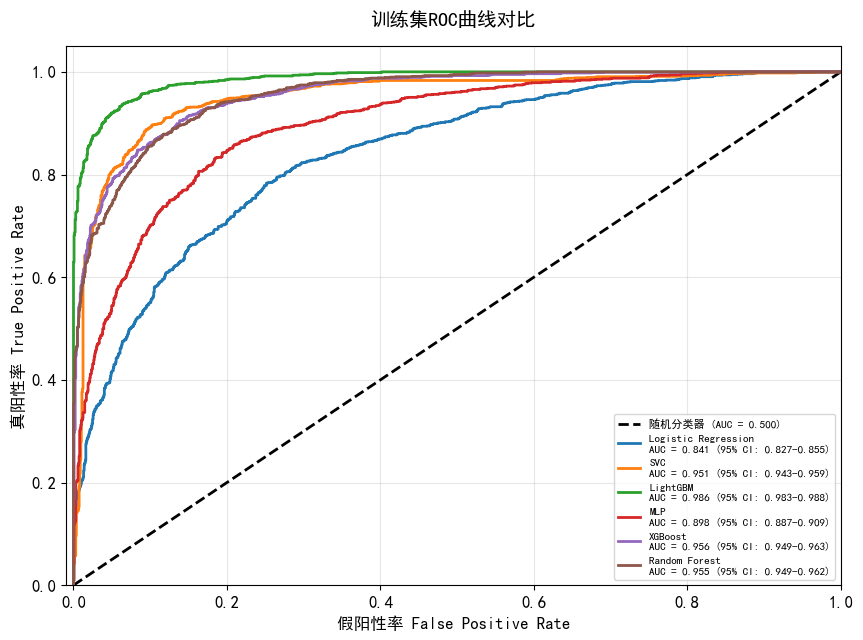

In [56]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows系统中文显示
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

# ====================== 定义Bootstrap AUC函数 ======================
def bootstrap_auc(y_true, y_proba, n_bootstraps=1000):
    bootstrapped_auc = []
    n_samples = len(y_true)
    
    for _ in range(n_bootstraps):
        indices = resample(np.arange(n_samples), replace=True)
        y_true_boot = y_true.iloc[indices] if hasattr(y_true, 'iloc') else y_true[indices]
        y_proba_boot = y_proba[indices]
        
        if len(np.unique(y_true_boot)) >= 2:
            fpr, tpr, _ = roc_curve(y_true_boot, y_proba_boot)
            bootstrapped_auc.append(auc(fpr, tpr))
    
    lower = np.percentile(bootstrapped_auc, 2.5)
    upper = np.percentile(bootstrapped_auc, 97.5)
    return lower, upper

# ====================== 绘图代码 ======================
plt.figure(figsize=(10, 7))
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='随机分类器 (AUC = 0.500)')

models = {
    "Logistic Regression": LOfinal_model,
    "SVC": SVCfinal_model,
    "LightGBM": GBMfinal_model,
    "MLP": MLPfinal_model,
    "XGBoost": XGBfinal_model,
    "Random Forest": RFfinal_model
}

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(x_train)[:, 1]
        fpr, tpr, _ = roc_curve(y_train, y_proba)
        roc_auc = auc(fpr, tpr)
        lower, upper = bootstrap_auc(y_train, y_proba, n_bootstraps=1000)
        label = f"{name}\nAUC = {roc_auc:.3f} (95% CI: {lower:.3f}-{upper:.3f})"
        plt.plot(fpr, tpr, lw=2, label=label)

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('假阳性率 False Positive Rate', fontsize=12)
plt.ylabel('真阳性率 True Positive Rate', fontsize=12)
plt.title('训练集ROC曲线对比', fontsize=14, pad=15)
plt.legend(loc='lower right', fontsize=8)
plt.grid(alpha=0.3)
plt.show()

验证集

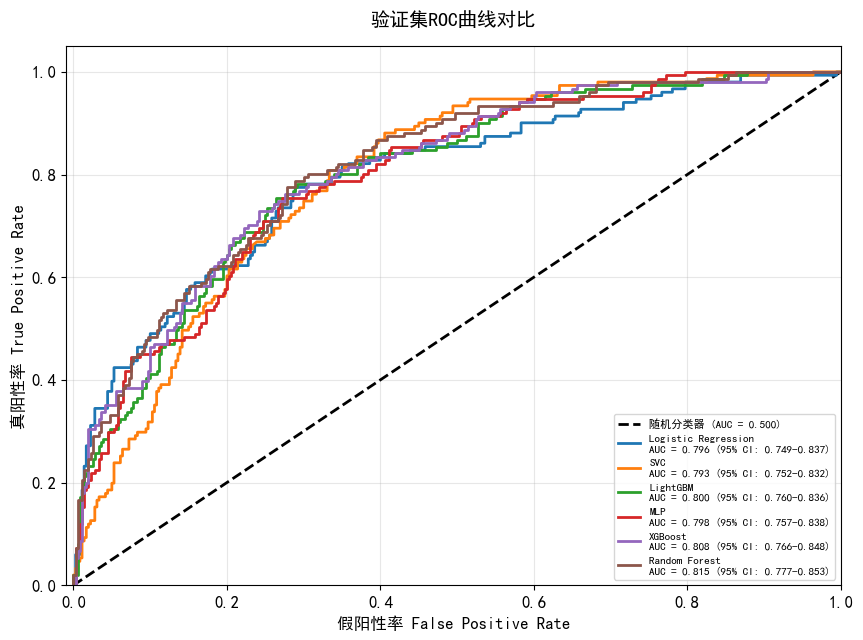

In [57]:
# ====================== 定义Bootstrap AUC函数 ======================
def bootstrap_auc(y_true, y_proba, n_bootstraps=1000):
    bootstrapped_auc = []
    n_samples = len(y_true)
    
    for _ in range(n_bootstraps):
        indices = resample(np.arange(n_samples), replace=True)
        y_true_boot = y_true.iloc[indices] if hasattr(y_true, 'iloc') else y_true[indices]
        y_proba_boot = y_proba[indices]
        
        if len(np.unique(y_true_boot)) >= 2:
            fpr, tpr, _ = roc_curve(y_true_boot, y_proba_boot)
            bootstrapped_auc.append(auc(fpr, tpr))
    
    lower = np.percentile(bootstrapped_auc, 2.5)
    upper = np.percentile(bootstrapped_auc, 97.5)
    return lower, upper

# ====================== 绘图代码 ======================
plt.figure(figsize=(10, 7))
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='随机分类器 (AUC = 0.500)')

models = {
    "Logistic Regression": LOfinal_model,
    "SVC": SVCfinal_model,
    "LightGBM": GBMfinal_model,
    "MLP": MLPfinal_model,
    "XGBoost": XGBfinal_model,
    "Random Forest": RFfinal_model
}

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(x_val)[:, 1]
        fpr, tpr, _ = roc_curve(y_val, y_proba)
        roc_auc = auc(fpr, tpr)
        lower, upper = bootstrap_auc(y_val, y_proba, n_bootstraps=1000)
        label = f"{name}\nAUC = {roc_auc:.3f} (95% CI: {lower:.3f}-{upper:.3f})"
        plt.plot(fpr, tpr, lw=2, label=label)

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('假阳性率 False Positive Rate', fontsize=12)
plt.ylabel('真阳性率 True Positive Rate', fontsize=12)
plt.title('验证集ROC曲线对比', fontsize=14, pad=15)
plt.legend(loc='lower right', fontsize=8)
plt.grid(alpha=0.3)
plt.show()

测试集

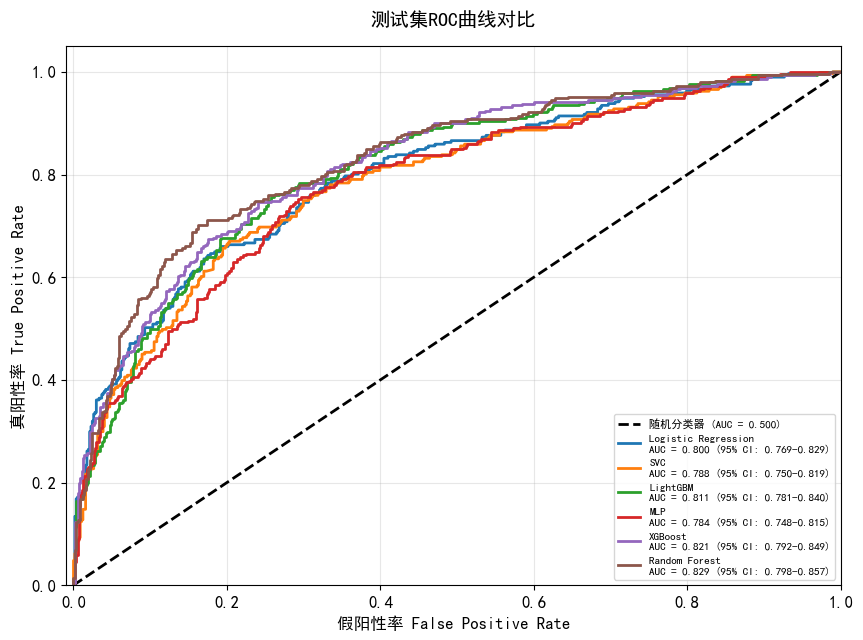

In [58]:
# ====================== 定义Bootstrap AUC函数 ======================
def bootstrap_auc(y_true, y_proba, n_bootstraps=1000):
    bootstrapped_auc = []
    n_samples = len(y_true)
    
    for _ in range(n_bootstraps):
        indices = resample(np.arange(n_samples), replace=True)
        y_true_boot = y_true.iloc[indices] if hasattr(y_true, 'iloc') else y_true[indices]
        y_proba_boot = y_proba[indices]
        
        if len(np.unique(y_true_boot)) >= 2:
            fpr, tpr, _ = roc_curve(y_true_boot, y_proba_boot)
            bootstrapped_auc.append(auc(fpr, tpr))
    
    lower = np.percentile(bootstrapped_auc, 2.5)
    upper = np.percentile(bootstrapped_auc, 97.5)
    return lower, upper

# ====================== 绘图代码 ======================
plt.figure(figsize=(10, 7))
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='随机分类器 (AUC = 0.500)')

models = {
    "Logistic Regression": LOfinal_model,
    "SVC": SVCfinal_model,
    "LightGBM": GBMfinal_model,
    "MLP": MLPfinal_model,
    "XGBoost": XGBfinal_model,
    "Random Forest": RFfinal_model
}

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(x_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        lower, upper = bootstrap_auc(y_test, y_proba, n_bootstraps=1000)
        label = f"{name}\nAUC = {roc_auc:.3f} (95% CI: {lower:.3f}-{upper:.3f})"
        plt.plot(fpr, tpr, lw=2, label=label)

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('假阳性率 False Positive Rate', fontsize=12)
plt.ylabel('真阳性率 True Positive Rate', fontsize=12)
plt.title('测试集ROC曲线对比', fontsize=14, pad=15)
plt.legend(loc='lower right', fontsize=8)
plt.grid(alpha=0.3)
plt.show()

In [62]:
# ====================== 定义模型字典 ======================
models = {
    "Logistic Regression": LOfinal_model,
    "SVC": SVCfinal_model,
    "LightGBM": GBMfinal_model,
    "MLP": MLPfinal_model,
    "XGBoost": XGBfinal_model,
    "Random Forest": RFfinal_model
}

# ====================== 校准曲线函数 ======================
def plot_calibration_curves(models_dict, X, y, dataset_name="", figsize=(14, 10)):
    plt.figure(figsize=figsize)
    plt.plot([0, 1], [0, 1], "k--", linewidth=3, label="完美校准", alpha=0.7)
    
    colors = plt.cm.tab20(np.linspace(0, 1, len(models_dict)))
    markers = ['o', 's', 'D', '^', 'v', 'P']
    
    for idx, (model_name, model) in enumerate(models_dict.items()):
        try:
            y_proba = model.predict_proba(X)[:, 1]  # 获取正类概率
        except AttributeError:
            print(f"{model_name} 不支持概率预测，已跳过")
            continue
        
        # 计算校准曲线
        prob_true, prob_pred = calibration_curve(
            y, y_proba, n_bins=15, strategy='quantile'
        )
        
        # 计算Brier分数
        brier = brier_score_loss(y, y_proba)
        
        # 绘制曲线
        plt.plot(prob_pred, prob_true, 
                marker=markers[idx % len(markers)],
                markersize=12,
                linestyle='-',
                linewidth=2.5,
                color=colors[idx],
                alpha=0.9,
                label=f"{model_name}\nBrier={brier:.3f}")
    
    # 图表美化
    plt.title(f"模型校准曲线对比 - {dataset_name}", fontsize=18, pad=20)
    plt.xlabel("预测概率分箱均值", fontsize=14)
    plt.ylabel("真实正例比例", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, alpha=0.2, linestyle='--')
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    
    leg = plt.legend(loc='upper left', 
                   bbox_to_anchor=(1.05, 1),
                   borderaxespad=0.5,
                   frameon=True,
                   edgecolor='#333333',
                   fontsize=11,
                   title="模型列表",
                   title_fontsize=12)
    leg.get_frame().set_facecolor('#F5F5F5')

# 测试集校准分析
plot_calibration_curves(
    models_dict=models,  
    X=x_test,
    y=y_test,
    dataset_name="测试集"
)

# 验证集校准分析
plot_calibration_curves(
    models_dict=models,
    X=x_val,
    y=y_val,
    dataset_name="验证集"
)

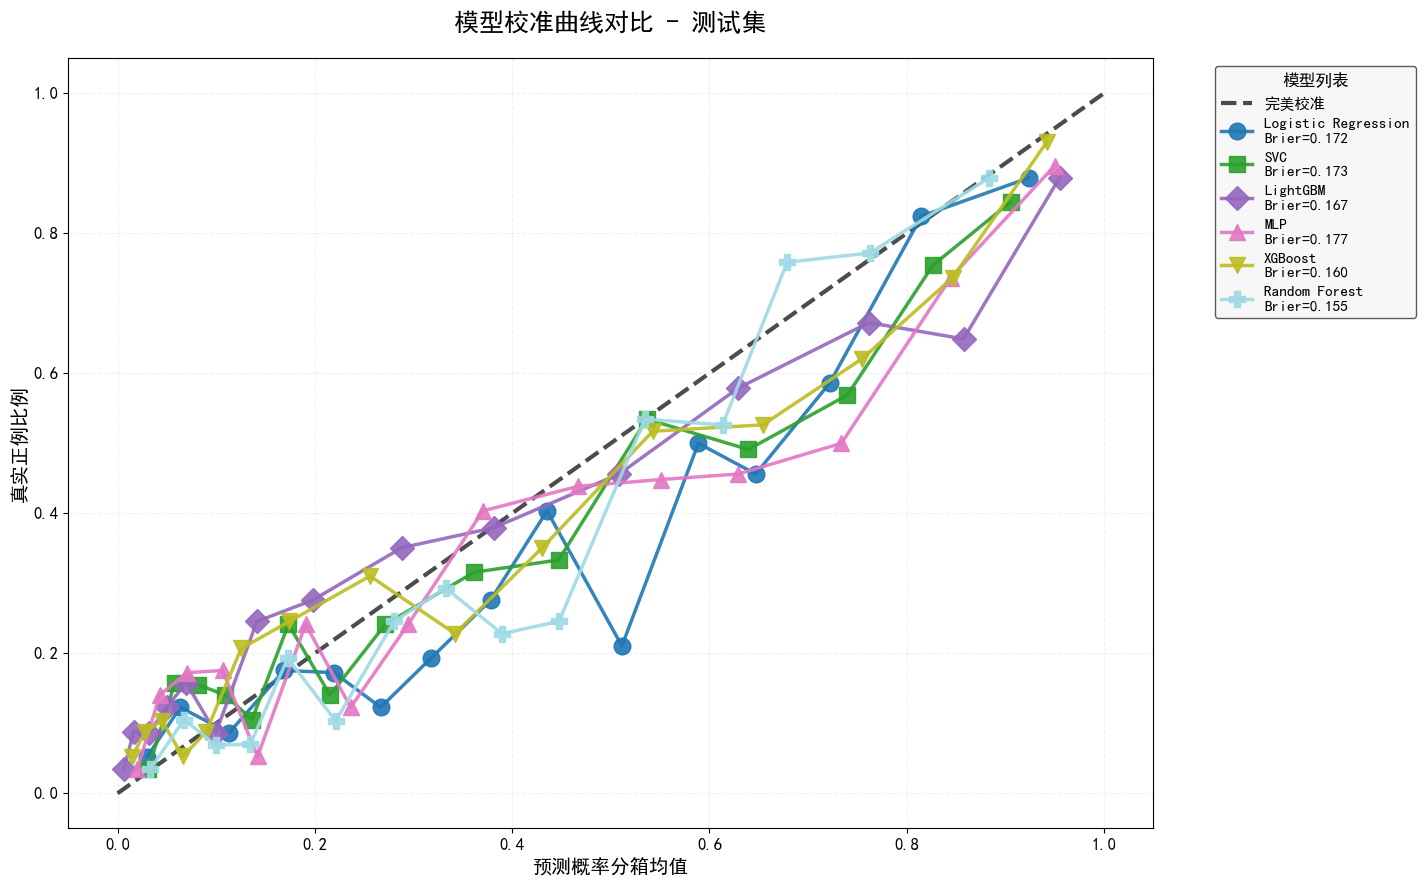

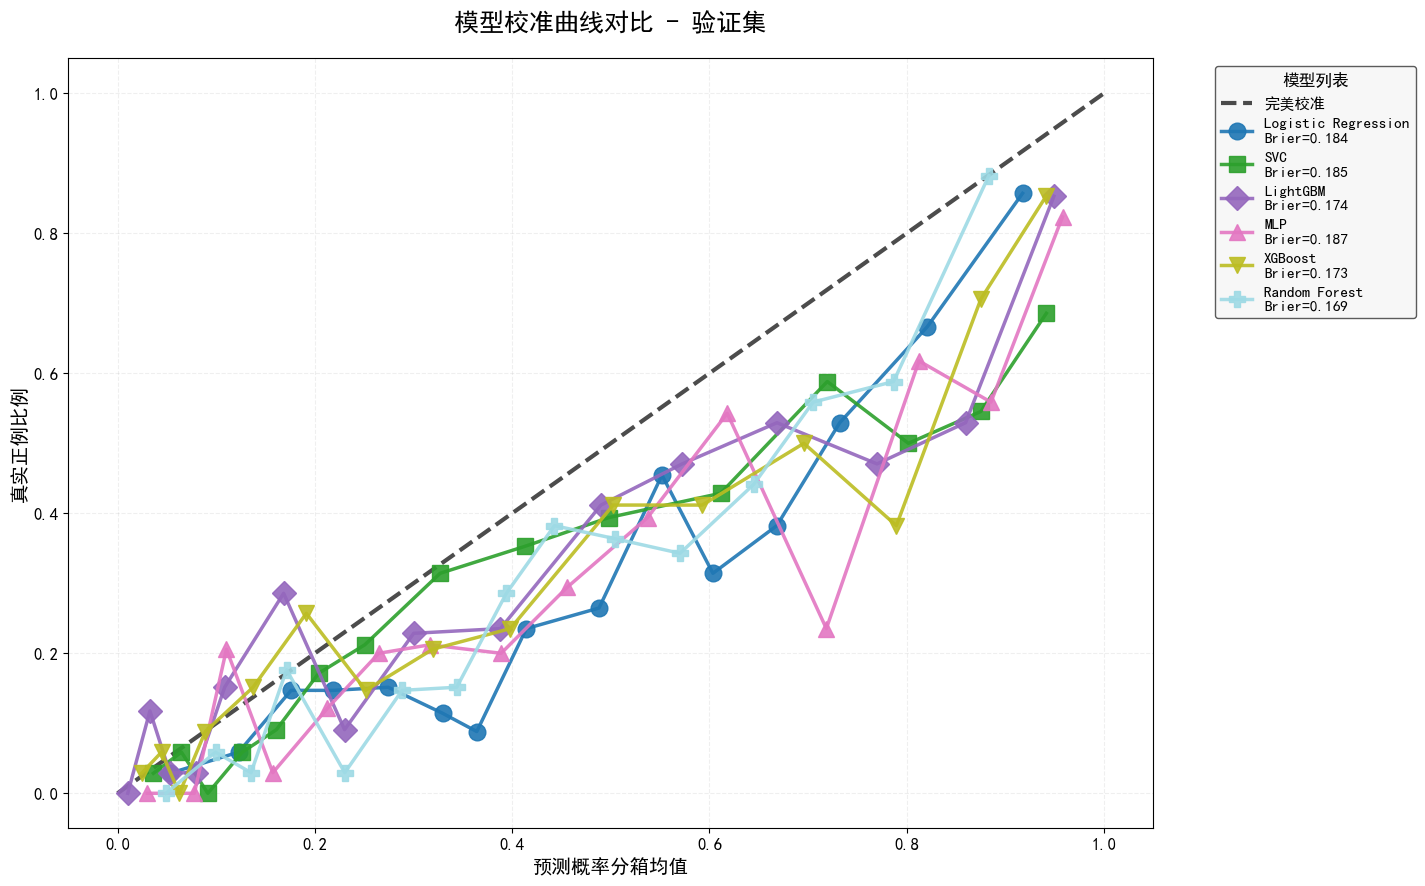

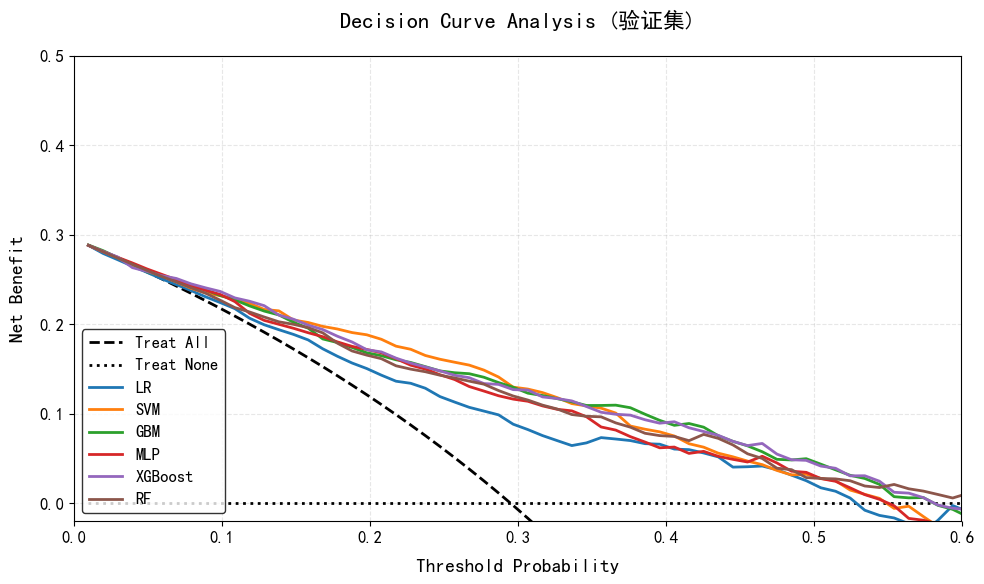

In [63]:
def calculate_net_benefit(y_true, y_prob, thresholds):
    net_benefits = []
    n = len(y_true)
    
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        net_benefit = (tp / n) - (fp / n) * (threshold / (1 - threshold))
        net_benefits.append(net_benefit)
    
    return np.array(net_benefits)

def plot_dca_validation(models, x_val, y_val):
    thresholds = np.linspace(0.01, 0.99, 100)
    
    plt.figure(figsize=(10, 6), dpi=100)
    plt.rc('font', size=12)

    # 基准线计算
    plt.plot(thresholds, 
             calculate_net_benefit(y_val, np.ones_like(y_val), thresholds),
             'k--', linewidth=2, label='Treat All')
    plt.plot(thresholds, 
             [0]*len(thresholds),  # Treat None的净收益始终为0
             'k:', linewidth=2, label='Treat None')

    # 自定义颜色方案
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', 
              '#d62728', '#9467bd', '#8c564b']
    
    # 按示例图顺序绘制模型
    for (name, model), color in zip(models.items(), colors):
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(x_val)[:, 1]
            
            label_map = {
                "Logistic Regression": "LR",
                "SVC": "SVM",
                "LightGBM":"GBM",
                "MLP":"MLP",
                "XGBoost": "XGBoost",
               "Random Forest": "RF", 
            }
            plt.plot(thresholds, 
                     calculate_net_benefit(y_val, y_prob, thresholds),
                     color=color,
                     linewidth=2,
                     label=label_map.get(name, name))

    # 坐标轴设置
    plt.xlim(0, 0.6)
    plt.ylim(-0.02, 0.5)  # 与示例图范围一致
    plt.xlabel("Threshold Probability", fontsize=14, labelpad=10)
    plt.ylabel("Net Benefit", fontsize=14, labelpad=10)
    plt.title("Decision Curve Analysis (验证集)", fontsize=16, pad=20)

    # 网格线和图例
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.legend(loc='lower left', frameon=True, 
              edgecolor='black', fontsize=12)

    plt.tight_layout()
    plt.show()

models = {
    "Logistic Regression": LOfinal_model, 
    "SVC": SVCfinal_model,
    "LightGBM": GBMfinal_model,
    "MLP": MLPfinal_model,
    "XGBoost": XGBfinal_model,
    "Random Forest": RFfinal_model
}

# 使用验证集数据
plot_dca_validation(models, x_val, y_val)

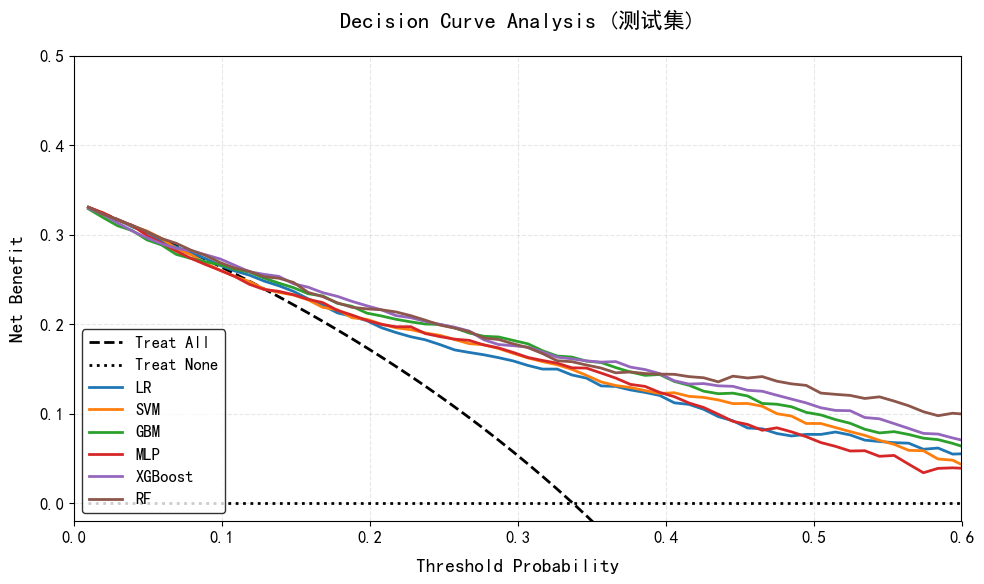

In [64]:
def calculate_net_benefit(y_true, y_prob, thresholds):
    net_benefits = []
    n = len(y_true)
    
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        net_benefit = (tp / n) - (fp / n) * (threshold / (1 - threshold))
        net_benefits.append(net_benefit)
    
    return np.array(net_benefits)

def plot_dca_validation(models, x_test, y_test):
    thresholds = np.linspace(0.01, 0.99, 100)
    plt.figure(figsize=(10, 6), dpi=100)
    plt.rc('font', size=12)

    # 基准线计算
    plt.plot(thresholds, 
             calculate_net_benefit(y_test, np.ones_like(y_test), thresholds),
             'k--', linewidth=2, label='Treat All')
    plt.plot(thresholds, 
             [0]*len(thresholds),  # Treat None的净收益始终为0
             'k:', linewidth=2, label='Treat None')

    # 自定义颜色方案
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', 
              '#d62728', '#9467bd', '#8c564b']
    
    # 按示例图顺序绘制模型（调整模型名称对应关系）
    for (name, model), color in zip(models.items(), colors):
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(x_test)[:, 1]
            label_map = {
                "Logistic Regression": "LR",
                "SVC": "SVM",
                "LightGBM":"GBM",
                "MLP":"MLP",
                "XGBoost": "XGBoost",
               "Random Forest": "RF", 
            }
            plt.plot(thresholds, 
                     calculate_net_benefit(y_test, y_prob, thresholds),
                     color=color,
                     linewidth=2,
                     label=label_map.get(name, name))

    # 坐标轴设置
    plt.xlim(0, 0.6)
    plt.ylim(-0.02, 0.5)  # 与示例图范围一致
    plt.xlabel("Threshold Probability", fontsize=14, labelpad=10)
    plt.ylabel("Net Benefit", fontsize=14, labelpad=10)
    plt.title("Decision Curve Analysis (测试集)", fontsize=16, pad=20)

    # 网格线和图例
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.legend(loc='lower left', frameon=True, 
              edgecolor='black', fontsize=12)

    plt.tight_layout()
    plt.show()

models = {
    "Logistic Regression": LOfinal_model, 
    "SVC": SVCfinal_model,
    "LightGBM": GBMfinal_model,
    "MLP": MLPfinal_model,
    "XGBoost": XGBfinal_model,
    "Random Forest": RFfinal_model
}

# 使用验证集数据
plot_dca_validation(models, x_test, y_test)

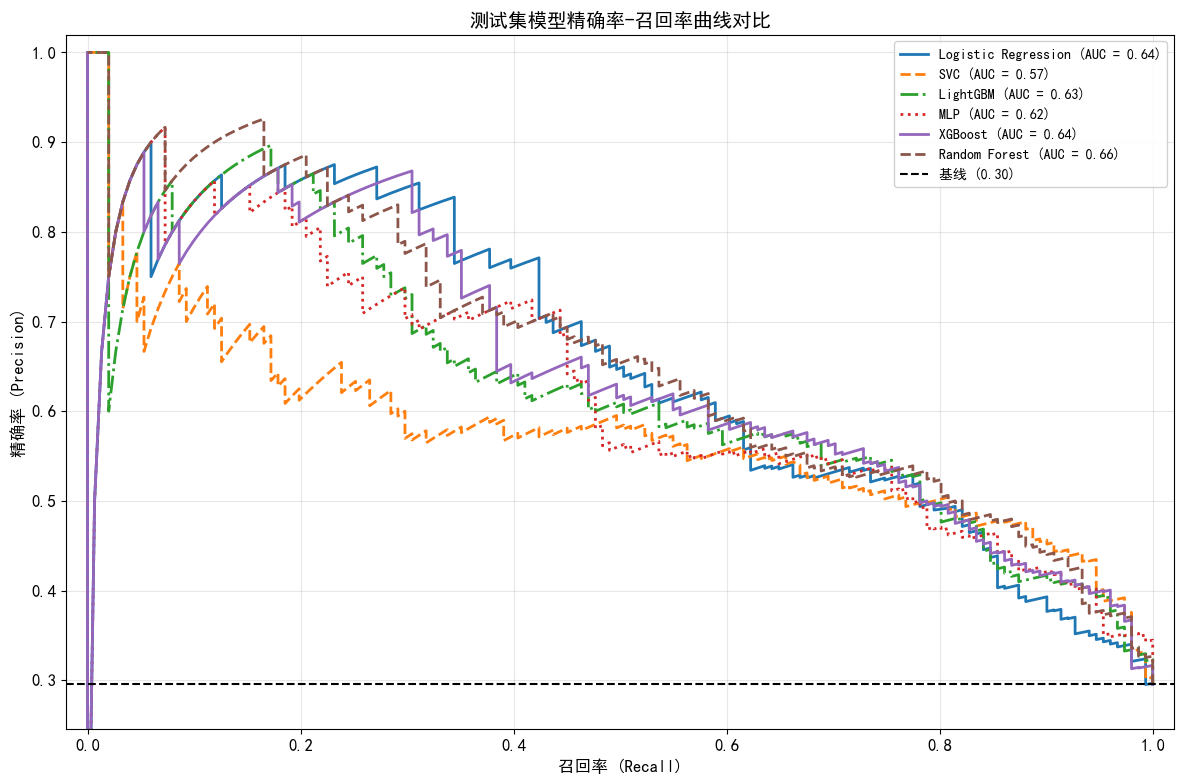

In [65]:
# ====================== 中文显示配置 ======================
plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows系统中文显示
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题


colors = plt.cm.tab10.colors
line_styles = ['-', '--', '-.', ':']

models = {
    "Logistic Regression": LOfinal_model, 
    "SVC": SVCfinal_model,
    "LightGBM": GBMfinal_model,
    "MLP": MLPfinal_model,
    "XGBoost": XGBfinal_model,
    "Random Forest": RFfinal_model
}

plt.figure(figsize=(12, 8))
baseline = np.mean(y_val)  # 正类比例

# 遍历所有模型
for idx, (model_name, model) in enumerate(models.items()):
    try:
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(x_val)[:, 1]
        elif hasattr(model, "decision_function"):
            y_proba = model.decision_function(x_val)
            y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())
        
        # 计算PR曲线
        precision, recall, _ = precision_recall_curve(y_val, y_proba)
        pr_auc = auc(recall, precision)
        
        # 绘制曲线
        plt.plot(recall, precision,
                 color=colors[idx % len(colors)],
                 linestyle=line_styles[idx % len(line_styles)],
                 lw=2,
                 label=f'{model_name} (AUC = {pr_auc:.2f})')
    except Exception as e:
        print(f"{model_name} 绘制失败: {str(e)}")

# 绘制参考线
plt.axhline(y=baseline, color='k', linestyle='--', label=f'基线 ({baseline:.2f})')

# 图表美化
plt.xlim([-0.02, 1.02])
plt.ylim([max(0, baseline-0.05), 1.02])
plt.xlabel('召回率 (Recall)', fontsize=12)
plt.ylabel('精确率 (Precision)', fontsize=12)
plt.title('测试集模型精确率-召回率曲线对比', fontsize=14)
plt.legend(loc='upper right' if baseline < 0.5 else 'lower left', fontsize=10, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

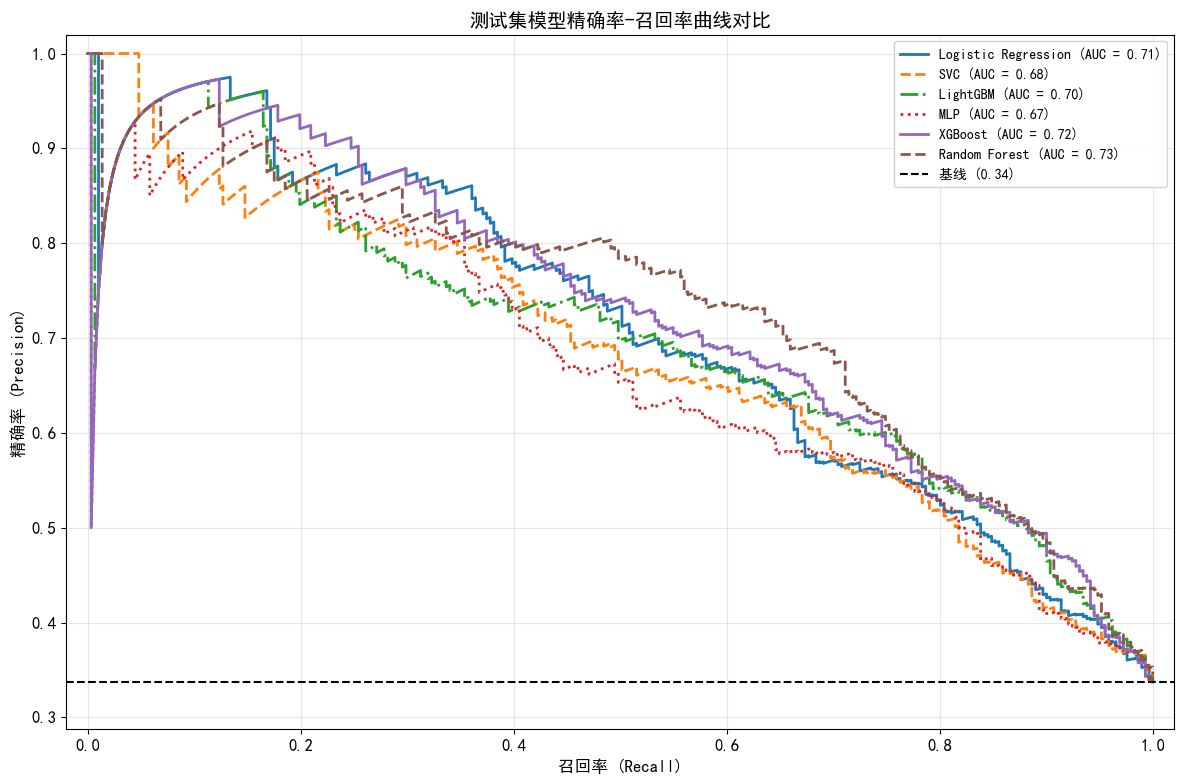

In [66]:
# ====================== 中文显示配置 ======================
plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows系统中文显示
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题


colors = plt.cm.tab10.colors
line_styles = ['-', '--', '-.', ':']

models = {
    "Logistic Regression": LOfinal_model, 
    "SVC": SVCfinal_model,
    "LightGBM": GBMfinal_model,
    "MLP": MLPfinal_model,
    "XGBoost": XGBfinal_model,
    "Random Forest": RFfinal_model
}

plt.figure(figsize=(12, 8))
baseline = np.mean(y_test)  # 正类比例

# 遍历所有模型
for idx, (model_name, model) in enumerate(models.items()):
    try:
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(x_test)[:, 1]
        elif hasattr(model, "decision_function"):
            y_proba = model.decision_function(x_test)
            y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())
        
        # 计算PR曲线
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        pr_auc = auc(recall, precision)
        
        # 绘制曲线
        plt.plot(recall, precision,
                 color=colors[idx % len(colors)],
                 linestyle=line_styles[idx % len(line_styles)],
                 lw=2,
                 label=f'{model_name} (AUC = {pr_auc:.2f})')
    except Exception as e:
        print(f"{model_name} 绘制失败: {str(e)}")

# 绘制参考线
plt.axhline(y=baseline, color='k', linestyle='--', label=f'基线 ({baseline:.2f})')

# 图表美化
plt.xlim([-0.02, 1.02])
plt.ylim([max(0, baseline-0.05), 1.02])
plt.xlabel('召回率 (Recall)', fontsize=12)
plt.ylabel('精确率 (Precision)', fontsize=12)
plt.title('测试集模型精确率-召回率曲线对比', fontsize=14)
plt.legend(loc='upper right' if baseline < 0.5 else 'lower left', fontsize=10, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

SHAP

In [14]:
import shap
from sklearn.ensemble import RandomForestClassifier  # 或RandomForestRegressor
from sklearn.pipeline import Pipeline

In [15]:
# 提取训练好的随机森林模型
XGB_model = XGBfinal_model.named_steps['clf']

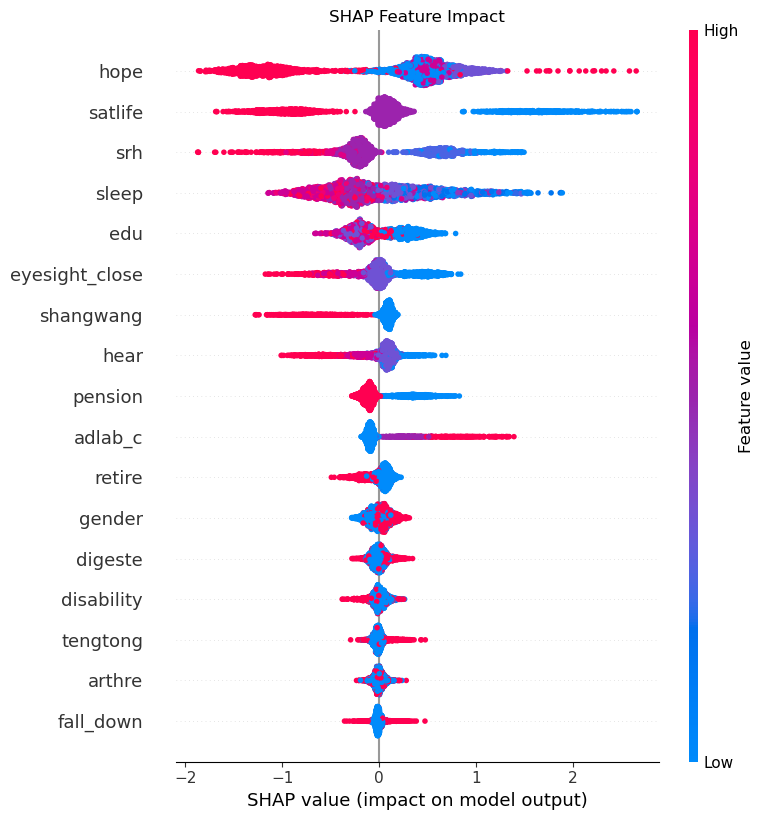

In [16]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# 创建SHAP解释器
explainer = shap.TreeExplainer(XGB_model)
# ----------------------------

# 计算SHAP值
shap_values = explainer.shap_values(x_train)


# 统一处理不同结构
if isinstance(shap_values, list):
    # 分类模型场景
    if len(shap_values) == 2:
        shap_values_pos = shap_values[1]  # 二分类取正类
    elif len(shap_values) > 2:
        class_idx = 1  # 多分类指定类别
        shap_values_pos = shap_values[class_idx]
    else:
        raise ValueError(f"不支持的分类数量: {len(shap_values)}")
elif isinstance(shap_values, np.ndarray):
    if shap_values.ndim == 2:
        shap_values_pos = shap_values  # 回归或单输出
    elif shap_values.ndim == 3:
        shap_values_pos = shap_values[:, :, 1]  # 多输出取正类
    else:
        raise ValueError(f"不支持的数组维度: {shap_values.ndim}")
else:
    raise ValueError(f"未知的SHAP值类型: {type(shap_values)}")

# 验证维度一致性
assert shap_values_pos.shape[1] == x_train.shape[1], \
    f"特征数不匹配: {shap_values_pos.shape[1]} vs {x_test.shape[1]}"

# 可视化
shap.summary_plot(
    shap_values_pos,
    x_train,
    feature_names=x_test.columns,
    plot_type='dot',
    show=False
)
plt.title("SHAP Feature Impact")
plt.tight_layout()
plt.show()

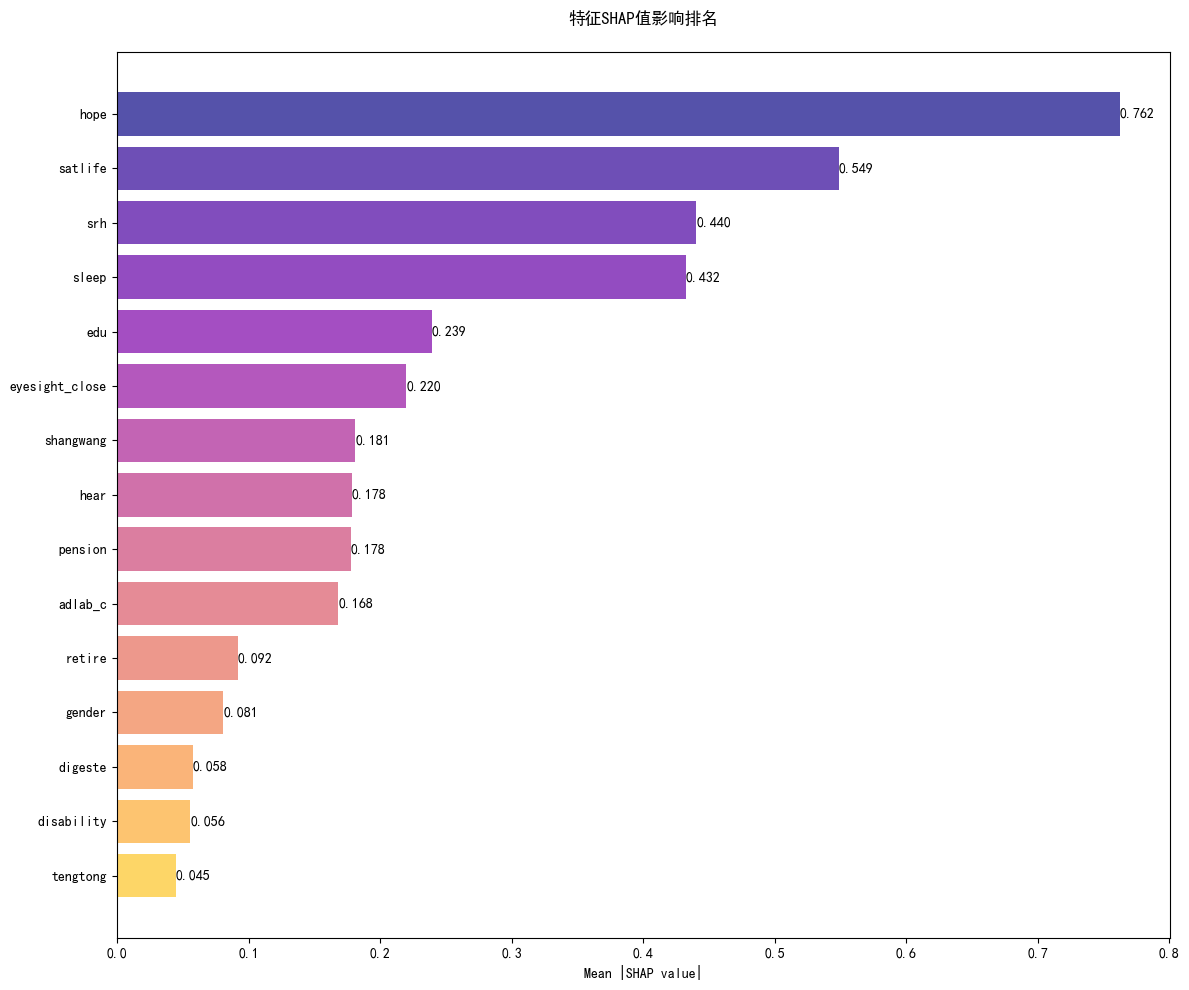

In [19]:
def plot_shap_bar(shap_values, feature_names, figsize=(10,8), 
                 color='#1f77b4', orientation='vertical', 
                 max_display=20, title=None):
    # 计算特征重要性（平均绝对SHAP值）
    if len(shap_values.shape) == 2:
        importance = np.abs(shap_values).mean(axis=0)
    elif len(shap_values.shape) == 3:
        importance = np.abs(shap_values).mean(axis=(0,1))
    else:
        raise ValueError("不支持的SHAP值维度: {}".format(shap_values.shape))
    
    # 创建排序索引（从高到低排序）
    idx = np.argsort(importance)[::-1]
    idx = idx[:max_display]
    
    sorted_importance = importance[idx]
    sorted_features = [feature_names[i] for i in idx]
    
    plt.figure(figsize=figsize)
    
    if orientation == 'vertical':
        bars = plt.bar(range(len(idx)), sorted_importance, 
                      color=color, alpha=0.7)
        plt.xticks(range(len(idx)), sorted_features, rotation=45, ha='right')
        plt.ylabel('Mean |SHAP value|')
        
    elif orientation == 'horizontal':
        # 关键修改点：反转y轴方向 + 调整标签位置
        y_pos = np.arange(len(idx))
        bars = plt.barh(y_pos, sorted_importance, 
                       color=color, alpha=0.7)
        plt.yticks(y_pos, sorted_features)
        plt.gca().invert_yaxis()  # 反转y轴，使最高值在顶部
        plt.xlabel('Mean |SHAP value|')
    else:
        raise ValueError("方向参数必须是 'vertical' 或 'horizontal'")
    
    # 添加数值标签（保持不变）
    for bar in bars:
        if orientation == 'vertical':
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom')
        else:
            width = bar.get_width()
            plt.text(width, bar.get_y() + bar.get_height()/2.,
                    f'{width:.3f}',
                    ha='left', va='center')
    
    if title is None:
        title = 'Feature Importance based on SHAP Values'
    plt.title(title, pad=20)
    
    plt.tight_layout()
    plt.show()

# 高级定制版水平柱状图
plot_shap_bar(shap_values_pos,
             feature_names=x_test.columns.tolist(),
             orientation='horizontal',
             color=plt.cm.plasma(np.linspace(0,1,x_test.shape[1])),
             figsize=(12,10),
             title='特征SHAP值影响排名',
             max_display=15)

In [20]:
XGB_model = XGBfinal_model.named_steps['clf']

<Figure size 1440x480 with 0 Axes>

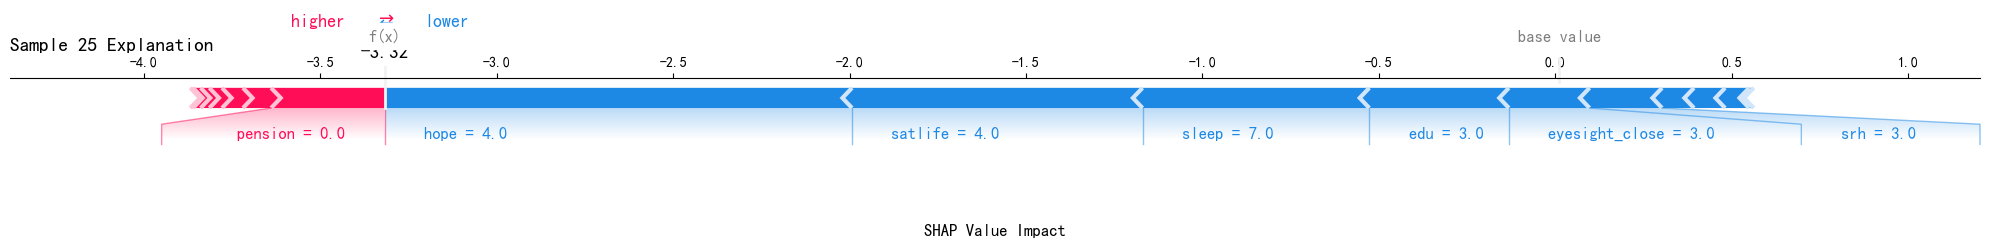

In [21]:
def plot_individual_shap(explainer, sample_data, sample_index=0, figsize=(10,5)):
    """
    生成单个样本的SHAP解释图（正确支持v0.20+版本）
    """
    # 计算SHAP值
    sample = sample_data.iloc[[sample_index]]  # 保持二维结构
    shap_values = explainer(sample)
    
    plt.figure(figsize=figsize, dpi=120)
    
    # 处理多分类情况（如果是多分类模型）
    if len(shap_values.shape) == 3:  # (样本数, 特征数, 类别数)
        class_index = 0  # 选择第一个类别进行可视化
        expected_value = explainer.expected_value[class_index]
        shap_array = shap_values.values[0, :, class_index]
    else:
        expected_value = explainer.expected_value
        shap_array = shap_values.values[0]

    # 正确的位置参数调用方式
    shap.plots.force(
        expected_value,         
        shap_array,              # 第二个位置参数：shap_values
        features=sample.iloc[0],            # 使用单个样本的Series
        feature_names=sample_data.columns.tolist(),
        matplotlib=True,
        show=False,
        text_rotation=0,
        contribution_threshold=0.05,
        plot_cmap=['#ff0d57', '#1e88e5']
    )
    
    # 优化显示
    ax = plt.gca()
    ax.set_xlabel("SHAP Value Impact", fontsize=12, labelpad=10, fontweight='semibold')
    ax.tick_params(axis='x', labelsize=10)
    ax.set_title(f"Sample {sample_index} Explanation", 
                fontsize=14, pad=20, fontweight='bold', loc='left')
    plt.tight_layout()
    plt.show()



# 使用示例
# 假设已有预处理好的数据x和训练好的explainer
plot_individual_shap(explainer=explainer, 
                    sample_data=x_val, 
                    sample_index=25,  # 选择需要解释的样本索引
                    figsize=(12,4))

<Figure size 1440x480 with 0 Axes>

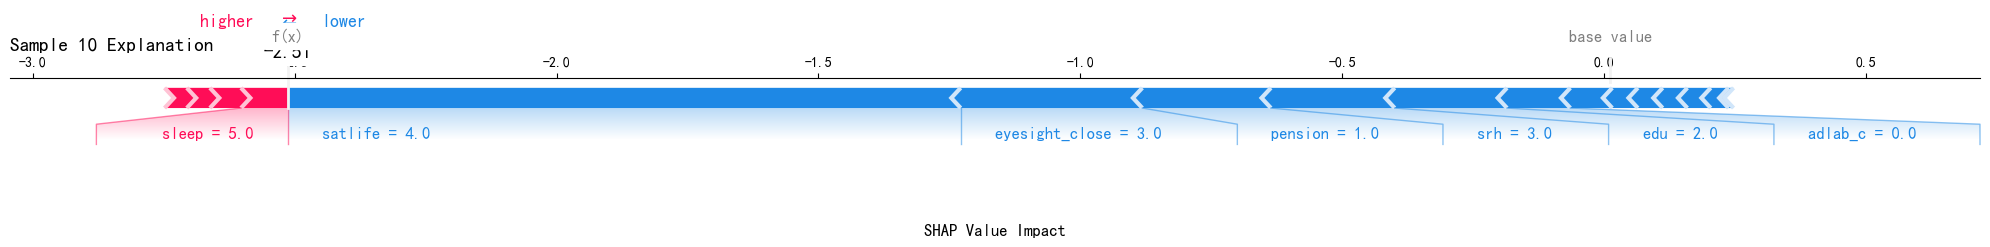

In [22]:
def plot_individual_shap(explainer, sample_data, sample_index=0, figsize=(10,5)):
    """
    生成单个样本的SHAP解释图（正确支持v0.20+版本）
    """
    # 计算SHAP值
    sample = sample_data.iloc[[sample_index]]  # 保持二维结构
    shap_values = explainer(sample)
    
    plt.figure(figsize=figsize, dpi=120)
    
    # 处理多分类情况（如果是多分类模型）
    if len(shap_values.shape) == 3:  # (样本数, 特征数, 类别数)
        class_index = 0  # 选择第一个类别进行可视化
        expected_value = explainer.expected_value[class_index]
        shap_array = shap_values.values[0, :, class_index]
    else:
        expected_value = explainer.expected_value
        shap_array = shap_values.values[0]

    # 正确的位置参数调用方式
    shap.plots.force(
        expected_value,          # 第一个位置参数：base_value
        shap_array,              # 第二个位置参数：shap_values
        features=sample.iloc[0],            # 使用单个样本的Series
        feature_names=sample_data.columns.tolist(),
        matplotlib=True,
        show=False,
        text_rotation=0,
        contribution_threshold=0.05,
        plot_cmap=['#ff0d57', '#1e88e5']
    )
    
    # 优化显示
    ax = plt.gca()
    ax.set_xlabel("SHAP Value Impact", fontsize=12, labelpad=10, fontweight='semibold')
    ax.tick_params(axis='x', labelsize=10)
    ax.set_title(f"Sample {sample_index} Explanation", 
                fontsize=14, pad=20, fontweight='bold', loc='left')
    plt.tight_layout()
    plt.show()



# 使用示例
# 假设已有预处理好的数据x和训练好的explainer
plot_individual_shap(explainer=explainer, 
                    sample_data=x_val, 
                    sample_index=10,  # 选择需要解释的样本索引
                    figsize=(12,4))

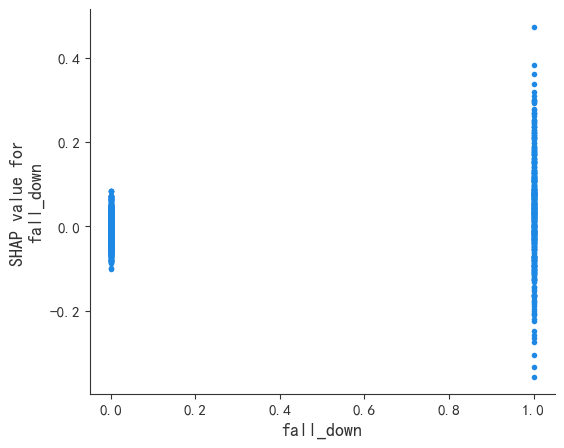

In [29]:
import shap
import matplotlib.pyplot as plt
import xgboost as xgb
# 创建SHAP解释器 (TreeExplainer适合XGBoost模型)
explainer = shap.TreeExplainer(XGB_model )

# 计算SHAP值
shap_values = explainer.shap_values(x_train)

# 绘制某个特征（例如 "edu"）的依赖图
#shap.dependence_plot("fall_down", shap_values, x_val, interaction_index=None)

# 如果想分析特征之间交互效应：
shap.dependence_plot("fall_down", shap_values, x_train, interaction_index=None)

plt.show()